# Tutorial: Ensemble Methods for Wind Capacity Factor Prediction

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2F08_tutorial_ensemble_methods_windcf_prediction.ipynb)

Tutorial to the class [Ensemble Methods](08_ensemble_methods.ipynb) based on the same case study as in [Tutorial: Regularization, Model Selection and Evaluation](05_tutorial_regularization_selection_evaluation.ipynb) and [Tutorial: Introduction to Unsupervised Learning with a Focus on PCA](08_tutorial_unsupervised_learning_pca.ipynb).

<div class="alert alert-block alert-info">
    <b>Tutorial Objectives</b>
    
- Use ensemble methods to best predict the France-average wind capacity factor from a large number of input variables;
- Control the complexity parameter(s) of each ensemble method to avoid overfitting;
- Compare the skills of different methods.
</div>

## Scientific objective

To predict the France average wind capacity factor from the geopotential height at 500hPa over the Euro-Atlantic sector.

## Dataset presentation

- Input:
  - [Geopotential height](https://en.wikipedia.org/wiki/Geopotential_height) at 500hPa
    - Domain: North Atlantic
    - Spatial resolution: $0.5° \times 0.625°$
    - Time resolution: monthly
    - Period: 1980-2021
    - Units: m
    - Source: [MERRA-2 reanalysis](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/)
- Target:
  - Onshore wind capacity factors
    - Domain: Metropolitan France
    - Spatial resolution: regional mean
    - Time resolution: daily
    - Period: 2014-2021
    - Units:
    - Source: [RTE](https://opendata.reseaux-energies.fr/)

## Getting ready

### Reading the wind capacity factor and geopotential height data

We follow the same procedure as in [# Tutorial: Regularization, Model Selection and Evaluation](05_tutorial_regularization_selection_evaluation.ipynb).

In [1]:
# Path manipulation module
from pathlib import Path
# Numerical analysis module
import numpy as np
# Formatted numerical analysis module
import pandas as pd
# Structured dataset analysis module
import xarray as xr
# Plot module
import matplotlib.pyplot as plt
# Default colors
RC_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Matplotlib configuration
plt.rc('font', size=14)

# Set data directory
data_dir = Path('data')

# Set keyword arguments for pd.read_csv
kwargs_read_csv = dict(index_col=0, parse_dates=True) 

# Define electricity demand filepath and label
windcf_filename = 'reseaux_energies_capacityfactor_wind-onshore.csv'
windcf_filepath = Path(data_dir, windcf_filename)
windcf_label = 'Wind capacity factor'

# Read windcf data with pandas                                                                                                                                                
df_windcf_daily = pd.read_csv(windcf_filepath, **kwargs_read_csv)

# Select domain
# REGION_NAME = 'Bretagne'
REGION_NAME = 'National'
if REGION_NAME == 'National':
    df_windcf_daily_reg = df_windcf_daily.mean('columns')
    df_windcf_daily_reg.name = REGION_NAME
else:
    df_windcf_daily_reg = df_windcf_daily[REGION_NAME]

# Resample wind capacity factor from daily to monthly means
df_windcf_reg = df_windcf_daily_reg.resample('MS').mean()

# Define temperature filepath and label
START_DATE = '19800101'
END_DATE = '20220101'
z500_filename = 'merra2_analyze_height_500_month_{}-{}.nc'.format(START_DATE, END_DATE)
z500_filepath = Path(data_dir, z500_filename)
z500_label = 'Geopotential height (m)'

# Read geopotential height dataset with xarray                                                                                                                                
ds = xr.load_dataset(z500_filepath)

# Select geopotential height variable                                                                                                                                         
z500_name = 'height_500'                                                                                                                                                     
da_z500_hr = ds[z500_name]

# Downsample geopotential height
N_GRID_AVG = 8
da_z500 = da_z500_hr.coarsen(lat=N_GRID_AVG, boundary='trim').mean().coarsen(                                                                                                 
    lon=N_GRID_AVG, boundary='trim').mean()

# Remove seasonal cycle from wind capacity factor
da_windcf_reg = df_windcf_reg.to_xarray()                                                                                                                                 
gp_windcf_cycle = da_windcf_reg.groupby('time.month')                                                                                                                     
da_windcf_anom = gp_windcf_cycle - gp_windcf_cycle.mean('time')                                                                                                           
df_windcf_anom = da_windcf_anom.drop('month').to_dataframe()[REGION_NAME]

# Remove seasonal cycle from geopotential height or not
gp_z500_cycle = da_z500.groupby('time.month')                                                                                                                             
da_z500_anom = gp_z500_cycle - gp_z500_cycle.mean('time')

# Convert to bandas with grid points as columns                                                                                                                               
df_z500_anom = da_z500_anom.stack(latlon=('lat', 'lon')).to_dataframe()[
    z500_name].unstack(0).transpose()
    
# Select common index                                                                                                                                                         
idx = df_z500_anom.index.intersection(df_windcf_anom.index)                                                                                                                   
df_z500_anom = df_z500_anom.loc[idx]                                                                                                                                          
df_windcf_anom = df_windcf_anom.loc[idx]                                                                                                                                      
                                                                                                                                                                              
# Number of years in dataset                                                                                                                                                  
time = df_windcf_anom.index                                                                                                                                                   
n_years = time.year.max() - time.year.min() + 1

## Ensemble methods

### Regressions evaluation function

We also define a function to evaluate any of our regressions.

`FIRST_TEST_YEAR` controls the number of years at the end of the time series to keep as test data.

In [2]:
from sklearn import model_selection

# Default number of test days
FIRST_TEST_YEAR = 2020

POLY_DEGREE = 1

# Get input matrix and output vector for whole time series
X = df_z500_anom.values
y = df_windcf_anom.values

def evaluate_regressor(
    reg, reg_kwargs, param_name, param_range, first_test_year=FIRST_TEST_YEAR,
    n_splits=None, cv_iterator=model_selection.KFold,
    plot_validation=True):
    
    if n_splits is None:
        n_splits = len(np.unique(time[time.year < first_test_year].year))
    
    # Get test data keeping last years
    index_test = time.year >= first_test_year
    X_test = X[index_test]
    y_test = y[index_test]
    
    # Select train data from first years and first days in month 
    index_cv = time.year < first_test_year
    X_cv = X[index_cv]
    y_cv = y[index_cv]
    
    if plot_validation:
        # Set cross-validation iterator
        cv = cv_iterator(n_splits=n_splits)
        groups = time[index_cv].year

        # Get train and validation scores from cross-validation
        train_scores, validation_scores = model_selection.validation_curve(
            reg, X_cv, y_cv, param_name=param_name,
            param_range=param_range, cv=cv, groups=groups)

        # Get train curve
        train_scores_mean = train_scores.mean(1)
        train_scores_max = train_scores.max(1)
        train_scores_min = train_scores.min(1)

        # Get validation curve
        validation_scores_mean = validation_scores.mean(1)
        validation_scores_max = validation_scores.max(1)
        validation_scores_min = validation_scores.min(1)

        # Get best value of the regularization parameter
        i_best = np.argmax(validation_scores_mean)
        param_best = param_range[i_best]
        score_best = validation_scores_mean[i_best]

    
        # Plot validation curve
        lw = 2
        plt.figure()
        plt.semilogx(param_range, train_scores_mean, label="Training score",
                     color="darkorange", lw=lw)
        plt.fill_between(param_range, train_scores_min, train_scores_max,
                         alpha=0.2, color="darkorange", lw=lw)
        plt.semilogx(param_range, validation_scores_mean,
                     label="Cross-validation score", color="navy", lw=lw)
        plt.fill_between(
            param_range, validation_scores_min, validation_scores_max,
            alpha=0.2, color="navy", lw=lw)
        plt.xlabel(param_name)
        plt.ylabel(r'Validation $R^2$')
        plt.xlim(param_range[[0, -1]])
        plt.title(REGION_NAME + r'. Best $R^2$: {:.2} for {} = {:.1e}'.format(
            score_best, param_name, param_best))
        # plt.ylim(0.0, 1.1)
        plt.legend(loc="best")
        
        # Set best parameter
        reg.set_params(**{param_name: param_best})
    else:
        param_best = reg.get_params(param_name)
        
    # Compute prediction error conditioned on first 5 years of data
    reg.fit(X_cv, y_cv)
    test_score = reg.score(X_test, y_test)
    print('\nTest R2: {:.2f}'.format(test_score))

    # Predict for work days and off days
    y_pred = reg.predict(X_test)

    # Scatter plot of prediction against target
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred, s=10, alpha=0.5)
    xlim = ax.get_xlim()
    ax.plot(xlim, xlim, '--k', linewidth=1)
    ax.set_xlabel('Target ' + windcf_label)
    ax.set_ylabel('Predicted ' + windcf_label)
    ax.set_xlim(xlim)
    ax.set_title('Wind capacity factor')
    
    return {param_name: param_best}

> ***Question***
> - If 2021 is given as the first test years, how many training years and test years will be available for this dataset?
> - Identify the lines where:
>   - The validation and train scores are computed;
>   - The test score is computed;
>   - The target is predicted from the test input features.

Answer: 

## Individual models

First, make sure that only the heating and cooling temperatures are selected as features, that the monthly factorization is activated and that no polynomial transformation is performed.

### Lasso regression

The following code:
- Creates a Lasso regressor with positive coefficients;
- Evaluate the regressor over a range of regularization parameter values;
- Represent the importance of the coefficients.

The evaluation function:
- Plots the training and validation curves with the lines representing the mean score and the shading the minimum and maximum scores;
- Plots test predictions against the test inputs over the train data;
- Plots the test predictions against the test targets.

> ***Question***
> - Is there an overfit/underfit tradeoff?
> - Explain the difference between the training curve and the validation curve?
> - Explain the evolution the variability of the validation curve.
> - Is the test score in agreement with the best validation score?
> - How does the the importance of the coefficients vary with climate variable and the month?


Test R2: 0.31


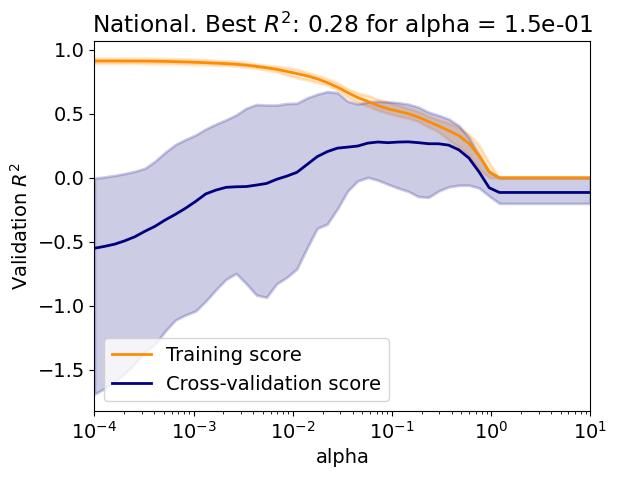

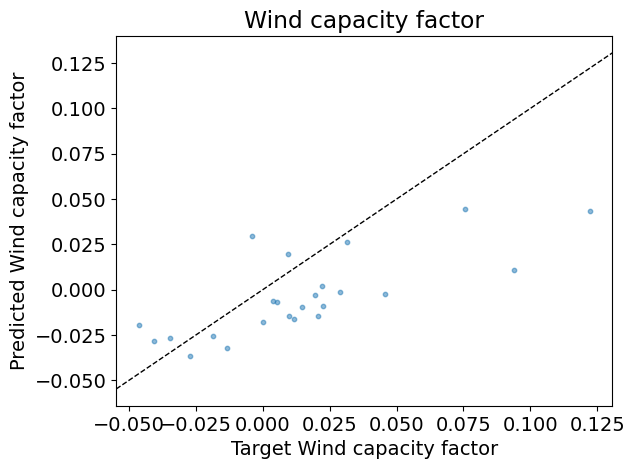

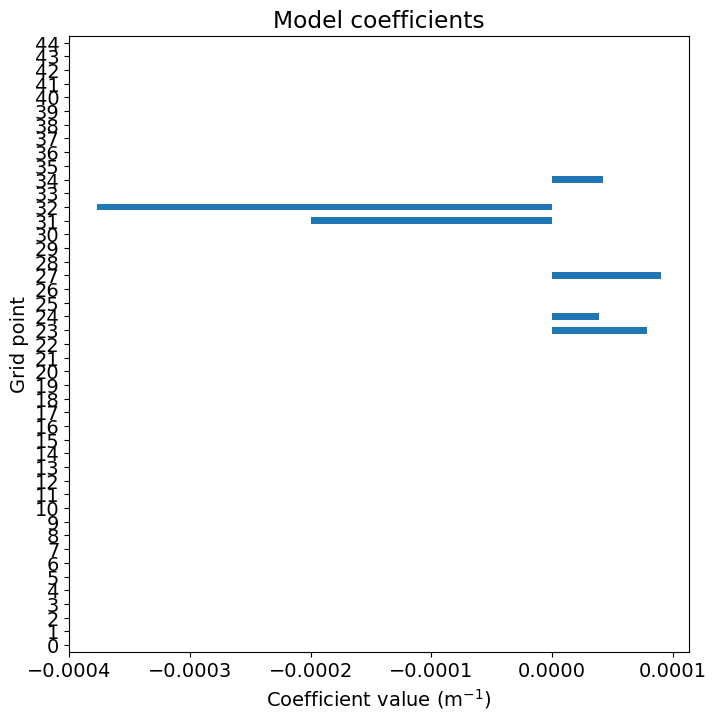

In [3]:
from sklearn import linear_model

# Define array of complexity coordinate, regressor and options
# for Lasso regression
param_name, param_range = 'alpha', np.logspace(-4, 1, 50)
reg_kwargs_lasso = dict(max_iter=10000)
reg_lasso = linear_model.Lasso(
    **{param_name: param_range[0]}, **reg_kwargs_lasso)

# Evaluate regressor
param_best_lasso = evaluate_regressor(
    reg_lasso, reg_kwargs_lasso, param_name, param_range)
df_coef = pd.Series(reg_lasso.coef_)
plt.figure()
df_coef.plot(kind='barh', figsize=(8, 8))
plt.xlabel(r'Coefficient value (m$^{-1}$)')
plt.ylabel('Grid point')
_ = plt.title('Model coefficients')

Answer:

### Decision-tree regression

The following code:
- Creates a decision-tree regressor;
- Evaluate the regressor over a range of maximum tree depth;

> ***Question***
> - Is there an overfit/underfit tradeoff?
> - How does the tree perform compared to the Lasso?


Test R2: -0.46


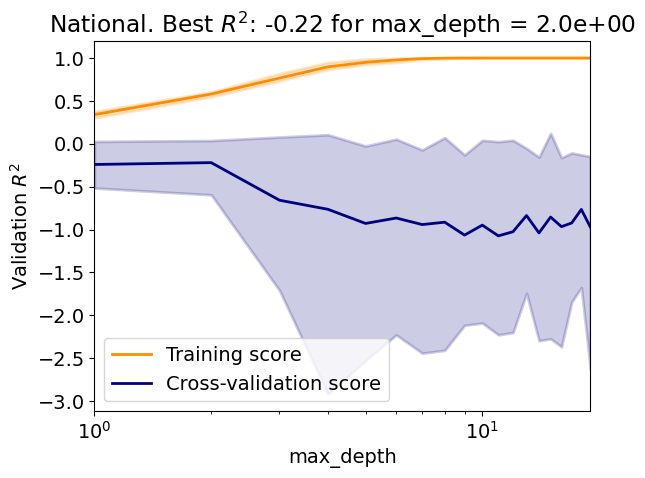

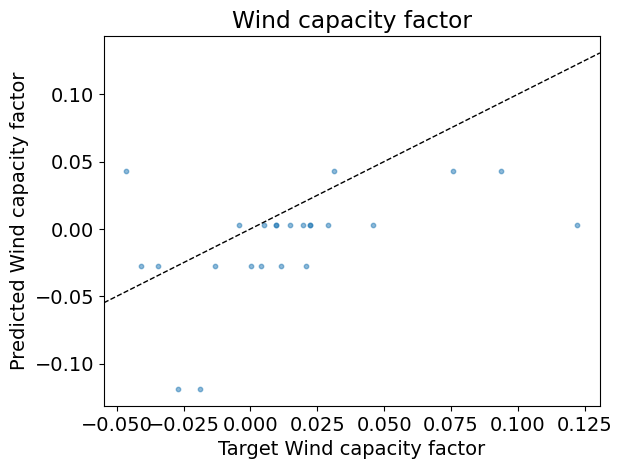

In [4]:
from sklearn import tree

# Define array of complexity coordinate, regressor and options
# for decision-tree regression
param_name, param_range = 'max_depth', np.arange(1, 20, 1)
reg_kwargs_dt = dict()
reg_dt = tree.DecisionTreeRegressor(
    **{param_name: param_range[0]}, **reg_kwargs_dt)

# Evaluate regressor
param_best_dt = evaluate_regressor(
    reg_dt, reg_kwargs_dt, param_name, param_range)

Answer:

## Ensemble models

### Bagging regressor

The following code:
- Creates a bagging regressor with a decision tree as the base estimator;
- Evaluate the regressor over a range of number of estimators;

> ***Question***
> - Use the Scikit-learn documentation to give the parameters defining this bagging regressor with a decision tree as the base estimator.

> ***Question***
> - Is there an overfit/underfit tradeoff?
> - In this case, how to choose the number of estimators?
> - Same question without using validation curves.
> - How does the bagging perform compared to the individual regressors?
> - Same question but with the Lasso as base estimator.

In [ ]:
from sklearn import ensemble

# Define array of complexity coordinate, regressor and options
# for Bagging regression
param_name, param_range = 'n_estimators', np.arange(1, 50, 2)
# estimator = None
estimator = linear_model.Lasso(alpha=0.15)
reg_kwargs_br = dict(estimator=estimator)
reg_br = ensemble.BaggingRegressor(
    **{param_name: param_range[0]}, **reg_kwargs_br)

# Evaluate regressor
param_best_br = evaluate_regressor(
    reg_br, reg_kwargs_br, param_name, param_range)

Answer:

### Random-forest regressor

The following code:
- Creates a random-forest regressor;
- Evaluate the regressor over a range of number of estimators;

> ***Question***
> - Use the Scikit-learn documentation to give the parameters defining this random-forest regressor.

> ***Question***
> - How does the random forest perform compared to the bagging regressor?
> - Compare the varibility of the validation score of the random forest to that of the bagging regressor.


Test R2: 0.28


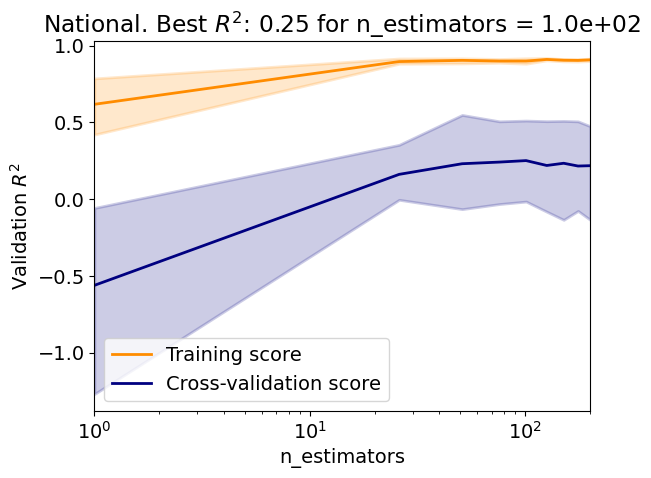

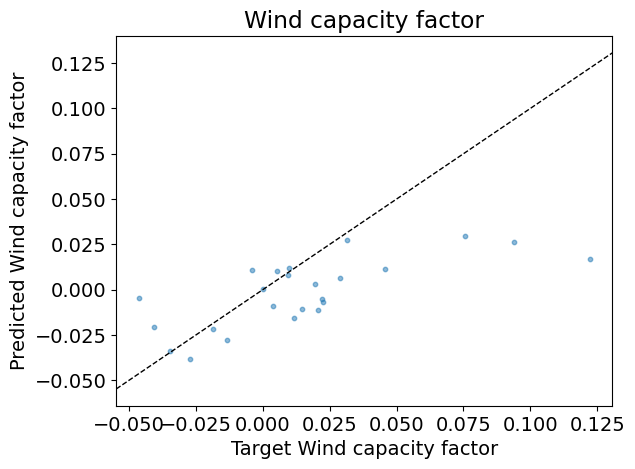

In [6]:
# Define array of complexity coordinate, regressor and options
# for random-forest regression
param_name, param_range = 'n_estimators', np.arange(1, 202, 25)
reg_kwargs_rf = dict()
reg_rf = ensemble.RandomForestRegressor(
    **{param_name: param_range[0]}, **reg_kwargs_rf)

# Evaluate regressor
param_best_rf = evaluate_regressor(
    reg_rf, reg_kwargs_rf, param_name, param_range)

Answer:

The following plot represents the mean and standard deviation of the importance given to the features by the trees in the random forest (see [Feature importance with a forest of trees in Scikit-learn User guide](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#feature-importances-with-a-forest-of-trees)).

> ***Question***
> - How does the the importance of the features vary with climate variable and the month?
> - Compare the importance of the random-forest features with that of the Lasso.

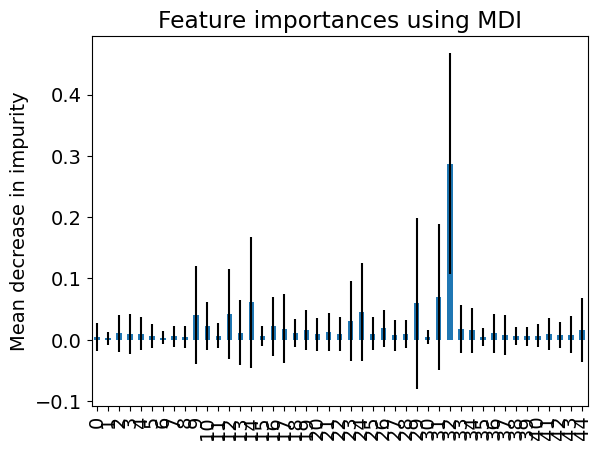

In [7]:
# Plot importance
importances = reg_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg_rf.estimators_], axis=0)
forest_importances = pd.Series(importances)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
_ = ax.set_ylabel("Mean decrease in impurity")

Answer:

### Voting regressor

The following code creates a voting regressor with the Lasso, the decision tree and the random forest as base estimators and tests it.

> ***Question***
> - Use the Scikit-learn documentation to give the parameters defining this voting regressor.

> ***Question***
> - How does the voting regressor perform compared to the base estimators?


Test R2: 0.15


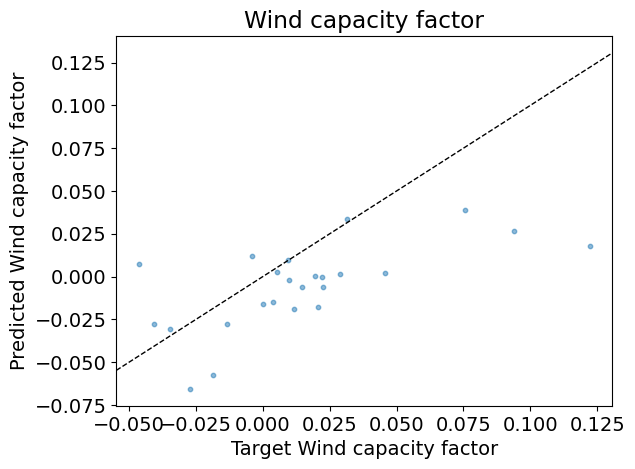

In [8]:
# Define array of complexity coordinate, regressor and options
# for voting regression
param_name, param_range = 'estimators', [
    [('Lasso', reg_lasso), ('DecisionTree', reg_dt), ('RandomForest', reg_rf)]
]
reg_kwargs_vr = dict()
reg_vr = ensemble.VotingRegressor(
    **{param_name: param_range[0]}, **reg_kwargs_vr)

# Evaluate regressor
param_best_vr = evaluate_regressor(
    reg_vr, reg_kwargs_vr, param_name, param_range,
    plot_validation=False)

Answer:

### Stacking regressor

- The following code creates a stacking regressor with the Lasso, the decision tree and the random forest as base estimators and tests it.
- The final regressor is a OLS with positive coefficients.
- The weights given to the base estimators by the stacking are also given.

> ***Question***
> - Use the Scikit-learn documentation to give the parameters defining this stacking regressor.

> ***Question***
> - How does the stacking regressor perform compared to the voting regressor? Why?


Test R2: 0.23
Weights:
Lasso           0.802294
DecisionTree    0.000000
RandomForest    0.187411
dtype: float64


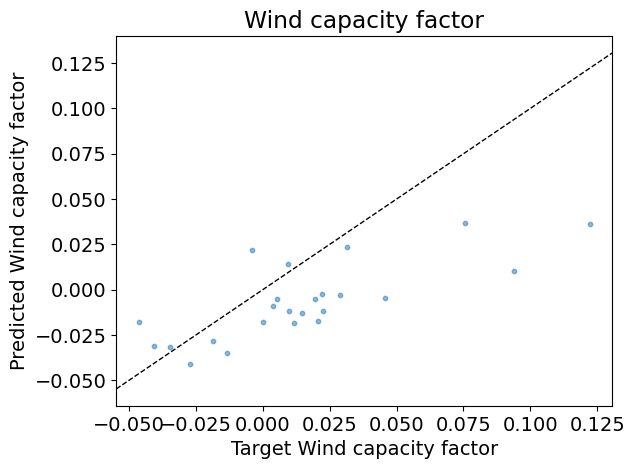

In [9]:
# Define array of complexity coordinate, regressor and options
# for voting regression
param_name, param_range = 'estimators', [
    [('Lasso', reg_lasso), ('DecisionTree', reg_dt), ('RandomForest', reg_rf)]
]
reg_kwargs_sr = dict(final_estimator=linear_model.LinearRegression(
    positive=True))
reg_sr = ensemble.StackingRegressor(
    **{param_name: param_range[0]}, **reg_kwargs_sr)

# Evaluate regressor
param_best_sr = evaluate_regressor(
    reg_sr, reg_kwargs_sr, param_name, param_range, plot_validation=False)
weights = reg_sr.final_estimator_.coef_
index = [r[0] for r in param_range[0]]
df_weights = pd.Series(weights, index=index)
print('Weights:')
print(df_weights)

Answer:

### AdaBoost regressor

The following code:
- Creates an AdaBoost regressor;
- Evaluate the regressor over a range of number of estimators;

> ***Question***
> - Use the Scikit-learn documentation to give the parameters defining this AdaBoost regressor.

> ***Question***
> - How does the AdaBoost compared to the other regressors?

In [ ]:
# Define array of complexity coordinate, regressor and options
# for AdaBoost regression
param_name, param_range = 'n_estimators', np.arange(1, 50, 2)
estimator = linear_model.LinearRegression(fit_intercept=True)
reg_kwargs_abr = dict(estimator=estimator)
reg_abr = ensemble.AdaBoostRegressor(
    **{param_name: param_range[0]}, **reg_kwargs_abr)

# Evaluate regressor
param_best_abr = evaluate_regressor(
    reg_abr, reg_kwargs_abr, param_name, param_range)

> ***Question (Optional)***
> - Reevaluate your results for a different scoring metric.

Answer: 

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>